In [86]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [87]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=4)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(
    # coeffs=[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5], 
    coeffs=[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2) @ qml.Identity(3),
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.Identity(3),
        qml.Identity(0) @ qml.Identity(1) @ qml.PauliZ(2) @ qml.PauliZ(3),
        qml.PauliZ(0) @ qml.Identity(1) @ qml.PauliZ(2) @ qml.Identity(3),
        qml.Identity(0) @ qml.PauliZ(1) @ qml.Identity(2) @ qml.PauliZ(3),
        qml.PauliZ(0) @ qml.Identity(1) @ qml.Identity(2) @ qml.PauliZ(3)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5, -0.5], 
    observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)]
)

In [88]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(7)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

In [89]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z1 = Paras_global[1]
    phi_z2 = Paras_global[2]
    phi_z3 = Paras_global[3]
    phi_z4 = Paras_global[4]
    tau_1 = Paras_global[5]
    tau_2 = Paras_global[6]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    qml.RY(np.pi/2, wires=3)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    qml.PhaseDamping(gamma_dephase, wires = 3)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    
    qml.RX(theta_x, wires = 2)    
    qml.RX(theta_x, wires = 3)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   
    qml.RY(-np.pi/2, wires = 2)   
    qml.RY(-np.pi/2, wires = 3)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    qml.PhaseDamping(gamma_dephase, wires = 3) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    qml.RY(np.pi/2, wires = 2) 
    qml.RY(np.pi/2, wires = 3) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    qml.PhaseDamping(gamma_dephase, wires = 3) 

    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    qml.RZ(phi_z4, wires=3)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    qml.RX(np.pi/(2), wires=2)
    qml.RX(np.pi/(2), wires=3)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2, 3])

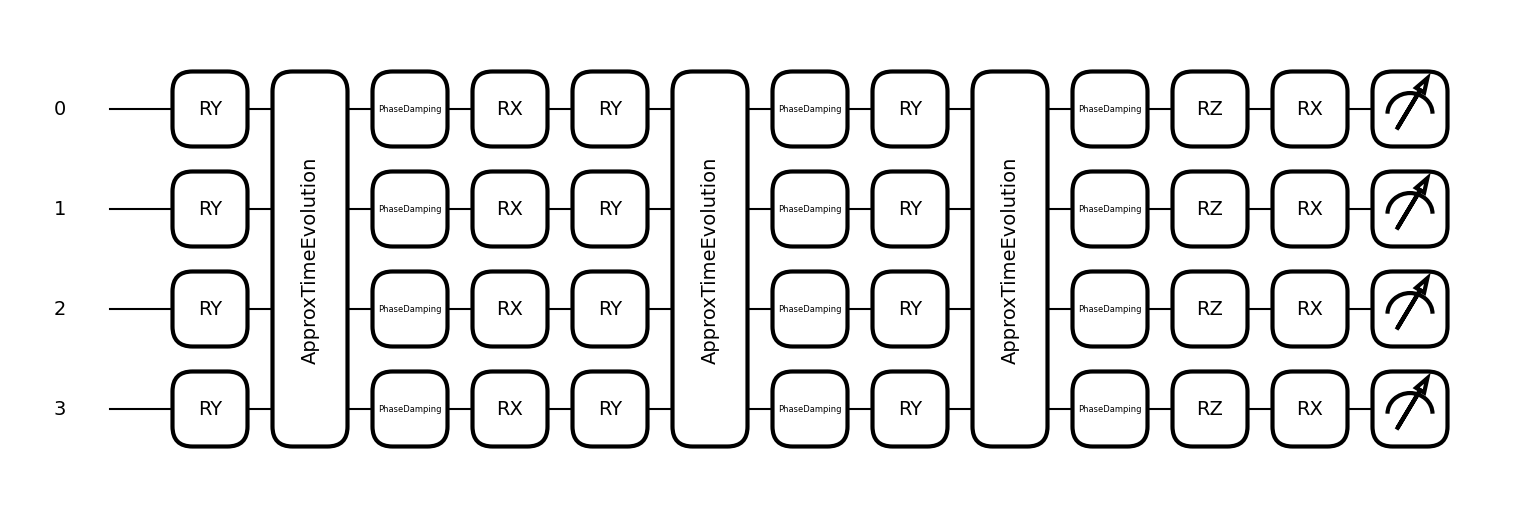

In [90]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [91]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, pnp.kron(K, pnp.kron(K, K))) @ get_density_matrix @ pnp.kron(K, pnp.kron(K, pnp.kron(K, K))).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2, 3])
    
    return qml.density_matrix(wires = [0, 1, 2, 3])  

In [92]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [93]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [94]:
class INDEX_3(Enum):
    THETA_X = 0
    
    PHI_Z1 = 1
    PHI_Z2 = 2
    PHI_Z3 = 3
    
    TAU_1 = 4
    TAU_2 = 5
    
def get_constraints(phi_current):
    N =2*np.pi * int(phi_current / (2*np.pi))
    default_0 = [
                (-float('inf'), float('inf')),              # THETA_X
                (-float('inf'), float('inf')),       # PHI_Z1
                (-float('inf'), float('inf')),  # PHI_Z2
                (-float('inf'), float('inf')),       # PHI_Z3
                (-float('inf'), float('inf')),   # tau_1
                (-float('inf'), float('inf')),          # tau_2
                (-float('inf'), float('inf'))          # tau_2
            ]
    # temp_0 = default_0
    
    # if 0.51 + N <= phi_current <= 0.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.07669747, 2.38469112) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (2.09160427, 2.37050667)
    #     return temp_0
        
    # elif 1.21 + N <= phi_current <= 1.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.77673923, 3.38486445) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-3.49168366, -2.91311528)
    #     return temp_0
    
    # elif 2.41 + N <= phi_current <= 3.01 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (3.97677551, 4.58495462) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-2.29178612, -1.71334716)
    #     return temp_0
    
    # elif 3.01 + N <= phi_current <= 3.61 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (-np.pi, 4.68483876)
    #     temp_0[INDEX_3.PHI_Z2.value] = (-1.71334716, -1.11319924)
    #     return temp_0

    # else: 
    return default_0


In [95]:
# ===================
tau_set = np.array([0])
gamma_ps_set = 0
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(7)
initial_parameters[:7] = 5e-1

# initial_parameters[0] = 0

sweep_range = np.array([1e-2, np.pi*2, 1e-2])
Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
Data = np.zeros((len(Phi), len(initial_parameters) + 2))
Data[:,0] = Phi
gradient = grad(cost_function)
hessian = jacobian(gradient)

for tau_idx, tau_current in enumerate(tau_set):
    set_circuit(tau_current, gamma_ps_set)
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)

        opt_result = sp.optimize.minimize(
            fun = cost_function, 
            x0 = initial_parameters, 
            method = 'L-BFGS-B', 
            # bounds = get_constraints(phi_current),
            bounds = [
                # (-float('inf'), float('inf')),  # phi_z2
                # (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf'))  # phi_z2
                
                # (-0.20191103, 3*np.pi/2),
                # (-0.20191103, 3*np.pi/2),
                # (-0.20191103, 3*np.pi/2),
                # (0.94764529,0.94764529),  # phi_z2
                # (0.73347877,0.73347877)  # phi_z2
            ], 

            jac = gradient,
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
        # print(get_constraints(phi_current))
        formatted_x = [f"{x:.8f}" for x in opt_result.x]
        print("CFI =", f"{-opt_result.fun:.5f}", "Paras =", formatted_x)

        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x

CFI = 13.45596 Paras = ['-0.57832312', '0.78253499', '0.78253499', '0.78253499', '0.78253499', '1.15437514', '3.44432949']
CFI = 13.45596 Paras = ['0.57832312', '1.17295477', '1.17295477', '1.17295477', '1.17295477', '2.72517147', '5.80052398']
CFI = 13.45596 Paras = ['2.14911945', '1.40858149', '1.40858149', '1.40858149', '1.40858149', '2.72517147', '7.76401939']


KeyboardInterrupt: 

In [ ]:
Data

array([[0.01, 4.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.02, 4.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.03, 4.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [6.26, 4.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [6.27, 4.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [6.28, 4.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
# np.savetxt("[0].csv", Data, delimiter=",")

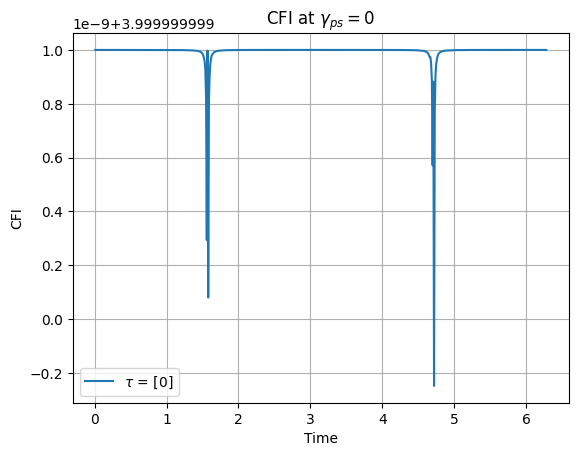

In [ ]:
plt.plot(Data[:,0], Data[:,1], label = f'$\\tau$ = {tau_set}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_set}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

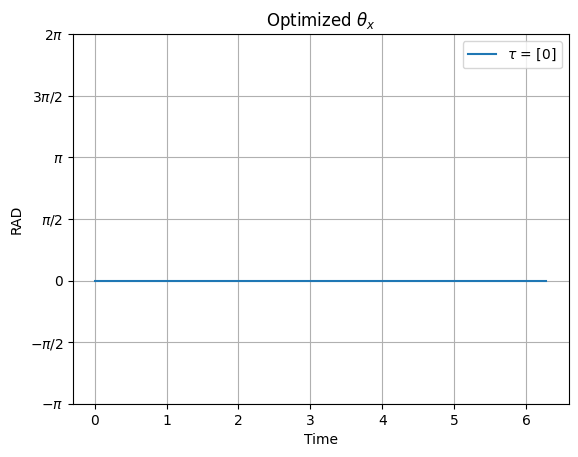

In [ ]:
plt.plot(Data[:,0], Data[:,2], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

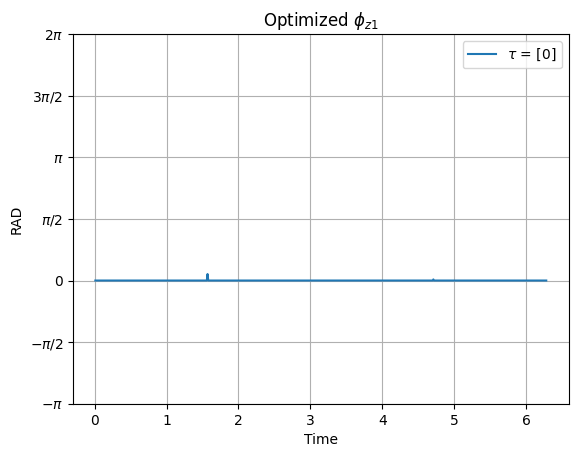

In [ ]:
plt.plot(Data[:,0], Data[:,3], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z1:", f"{Data[idx, 3]:.8f}")

PHI: 0.01 phi_z1: 0.00000000
PHI: 0.02 phi_z1: 0.00000000
PHI: 0.03 phi_z1: 0.00000000
PHI: 0.04 phi_z1: 0.00000000
PHI: 0.05 phi_z1: 0.00000000
PHI: 0.06 phi_z1: 0.00000000
PHI: 0.07 phi_z1: 0.00000000
PHI: 0.08 phi_z1: 0.00000000
PHI: 0.09 phi_z1: 0.00000000
PHI: 0.10 phi_z1: 0.00000000
PHI: 0.11 phi_z1: 0.00000000
PHI: 0.12 phi_z1: 0.00000000
PHI: 0.13 phi_z1: 0.00000000
PHI: 0.14 phi_z1: 0.00000000
PHI: 0.15 phi_z1: 0.00000000
PHI: 0.16 phi_z1: 0.00000000
PHI: 0.17 phi_z1: 0.00000000
PHI: 0.18 phi_z1: 0.00000000
PHI: 0.19 phi_z1: 0.00000000
PHI: 0.20 phi_z1: 0.00000000
PHI: 0.21 phi_z1: 0.00000000
PHI: 0.22 phi_z1: 0.00000000
PHI: 0.23 phi_z1: 0.00000000
PHI: 0.24 phi_z1: 0.00000000
PHI: 0.25 phi_z1: 0.00000000
PHI: 0.26 phi_z1: 0.00000000
PHI: 0.27 phi_z1: 0.00000000
PHI: 0.28 phi_z1: 0.00000000
PHI: 0.29 phi_z1: 0.00000000
PHI: 0.30 phi_z1: 0.00000000
PHI: 0.31 phi_z1: 0.00000000
PHI: 0.32 phi_z1: 0.00000000
PHI: 0.33 phi_z1: 0.00000000
PHI: 0.34 phi_z1: 0.00000000
PHI: 0.35 phi_

In [ ]:
get_constraints(1.51)

[(-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf)]

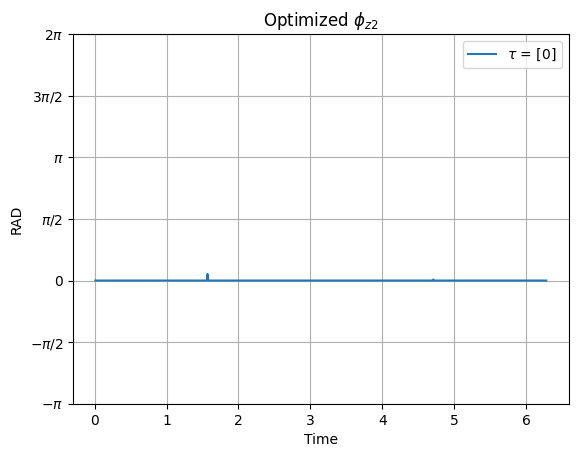

In [ ]:
plt.plot(Data[:,0], Data[:,4], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z2:", f"{Data[idx, 4]:.8f}")

PHI: 0.01 phi_z2: 0.00000000
PHI: 0.02 phi_z2: 0.00000000
PHI: 0.03 phi_z2: 0.00000000
PHI: 0.04 phi_z2: 0.00000000
PHI: 0.05 phi_z2: 0.00000000
PHI: 0.06 phi_z2: 0.00000000
PHI: 0.07 phi_z2: 0.00000000
PHI: 0.08 phi_z2: 0.00000000
PHI: 0.09 phi_z2: 0.00000000
PHI: 0.10 phi_z2: 0.00000000
PHI: 0.11 phi_z2: 0.00000000
PHI: 0.12 phi_z2: 0.00000000
PHI: 0.13 phi_z2: 0.00000000
PHI: 0.14 phi_z2: 0.00000000
PHI: 0.15 phi_z2: 0.00000000
PHI: 0.16 phi_z2: 0.00000000
PHI: 0.17 phi_z2: 0.00000000
PHI: 0.18 phi_z2: 0.00000000
PHI: 0.19 phi_z2: 0.00000000
PHI: 0.20 phi_z2: 0.00000000
PHI: 0.21 phi_z2: 0.00000000
PHI: 0.22 phi_z2: 0.00000000
PHI: 0.23 phi_z2: 0.00000000
PHI: 0.24 phi_z2: 0.00000000
PHI: 0.25 phi_z2: 0.00000000
PHI: 0.26 phi_z2: 0.00000000
PHI: 0.27 phi_z2: 0.00000000
PHI: 0.28 phi_z2: 0.00000000
PHI: 0.29 phi_z2: 0.00000000
PHI: 0.30 phi_z2: 0.00000000
PHI: 0.31 phi_z2: 0.00000000
PHI: 0.32 phi_z2: 0.00000000
PHI: 0.33 phi_z2: 0.00000000
PHI: 0.34 phi_z2: 0.00000000
PHI: 0.35 phi_

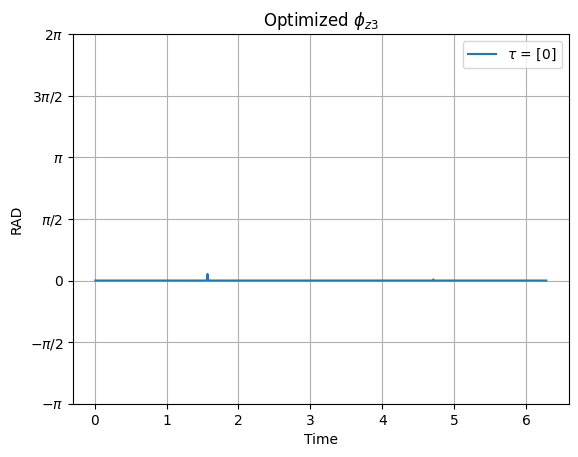

In [ ]:
plt.plot(Data[:,0], Data[:,5], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z3:", f"{Data[idx, 5]:.8f}")

PHI: 0.01 phi_z3: 0.00000000
PHI: 0.02 phi_z3: 0.00000000
PHI: 0.03 phi_z3: 0.00000000
PHI: 0.04 phi_z3: 0.00000000
PHI: 0.05 phi_z3: 0.00000000
PHI: 0.06 phi_z3: 0.00000000
PHI: 0.07 phi_z3: 0.00000000
PHI: 0.08 phi_z3: 0.00000000
PHI: 0.09 phi_z3: 0.00000000
PHI: 0.10 phi_z3: 0.00000000
PHI: 0.11 phi_z3: 0.00000000
PHI: 0.12 phi_z3: 0.00000000
PHI: 0.13 phi_z3: 0.00000000
PHI: 0.14 phi_z3: 0.00000000
PHI: 0.15 phi_z3: 0.00000000
PHI: 0.16 phi_z3: 0.00000000
PHI: 0.17 phi_z3: 0.00000000
PHI: 0.18 phi_z3: 0.00000000
PHI: 0.19 phi_z3: 0.00000000
PHI: 0.20 phi_z3: 0.00000000
PHI: 0.21 phi_z3: 0.00000000
PHI: 0.22 phi_z3: 0.00000000
PHI: 0.23 phi_z3: 0.00000000
PHI: 0.24 phi_z3: 0.00000000
PHI: 0.25 phi_z3: 0.00000000
PHI: 0.26 phi_z3: 0.00000000
PHI: 0.27 phi_z3: 0.00000000
PHI: 0.28 phi_z3: 0.00000000
PHI: 0.29 phi_z3: 0.00000000
PHI: 0.30 phi_z3: 0.00000000
PHI: 0.31 phi_z3: 0.00000000
PHI: 0.32 phi_z3: 0.00000000
PHI: 0.33 phi_z3: 0.00000000
PHI: 0.34 phi_z3: 0.00000000
PHI: 0.35 phi_

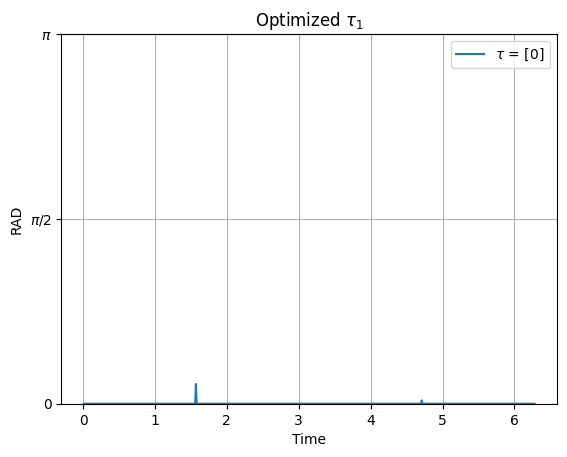

In [ ]:
plt.plot(Data[:,0], Data[:,6], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
Data[:,6]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [ ]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "tau_1:", f"{Data[idx, 6]:.8f}")

PHI: 0.01 tau_1: 0.00000000
PHI: 0.02 tau_1: 0.00000000
PHI: 0.03 tau_1: 0.00000000
PHI: 0.04 tau_1: 0.00000000
PHI: 0.05 tau_1: 0.00000000
PHI: 0.06 tau_1: 0.00000000
PHI: 0.07 tau_1: 0.00000000
PHI: 0.08 tau_1: 0.00000000
PHI: 0.09 tau_1: 0.00000000
PHI: 0.10 tau_1: 0.00000000
PHI: 0.11 tau_1: 0.00000000
PHI: 0.12 tau_1: 0.00000000
PHI: 0.13 tau_1: 0.00000000
PHI: 0.14 tau_1: 0.00000000
PHI: 0.15 tau_1: 0.00000000
PHI: 0.16 tau_1: 0.00000000
PHI: 0.17 tau_1: 0.00000000
PHI: 0.18 tau_1: 0.00000000
PHI: 0.19 tau_1: 0.00000000
PHI: 0.20 tau_1: 0.00000000
PHI: 0.21 tau_1: 0.00000000
PHI: 0.22 tau_1: 0.00000000
PHI: 0.23 tau_1: 0.00000000
PHI: 0.24 tau_1: 0.00000000
PHI: 0.25 tau_1: 0.00000000
PHI: 0.26 tau_1: 0.00000000
PHI: 0.27 tau_1: 0.00000000
PHI: 0.28 tau_1: 0.00000000
PHI: 0.29 tau_1: 0.00000000
PHI: 0.30 tau_1: 0.00000000
PHI: 0.31 tau_1: 0.00000000
PHI: 0.32 tau_1: 0.00000000
PHI: 0.33 tau_1: 0.00000000
PHI: 0.34 tau_1: 0.00000000
PHI: 0.35 tau_1: 0.00000000
PHI: 0.36 tau_1: 0.0

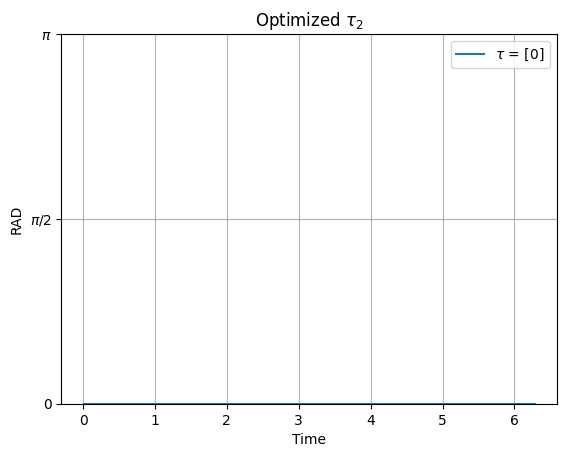

In [ ]:
plt.plot(Data[:,0], Data[:,7], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()